In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
! mkdir ~/.kaggle

In [11]:
! cp /content/drive/MyDrive/ColabNotebooks/KAGGLEAPI/kaggle.json ~/.kaggle/kaggle.json

In [12]:
! chmod 600 ~/.kaggle/kaggle.json

In [13]:
! kaggle datasets download ascanipek/eyepacs-aptos-messidor-diabetic-retinopathy

Dataset URL: https://www.kaggle.com/datasets/ascanipek/eyepacs-aptos-messidor-diabetic-retinopathy
License(s): other
100% 20.5G/20.5G [12:22<00:00, 31.0MB/s]
100% 20.5G/20.5G [12:22<00:00, 29.6MB/s]


In [24]:
!unzip eyepacs-aptos-messidor-diabetic-retinopathy.zip

Streaming output truncated to the last 5000 lines.
  inflating: dr_unified_v2/dr_unified_v2/val/0/35712_left.jpg  
  inflating: dr_unified_v2/dr_unified_v2/val/0/35713_left.jpg  
  inflating: dr_unified_v2/dr_unified_v2/val/0/3571_left.jpg  
  inflating: dr_unified_v2/dr_unified_v2/val/0/3572_right.jpg  
  inflating: dr_unified_v2/dr_unified_v2/val/0/35739_right.jpg  
  inflating: dr_unified_v2/dr_unified_v2/val/0/35742_right.jpg  
  inflating: dr_unified_v2/dr_unified_v2/val/0/35744_left.jpg  
  inflating: dr_unified_v2/dr_unified_v2/val/0/35751_right.jpg  
  inflating: dr_unified_v2/dr_unified_v2/val/0/35762_left.jpg  
  inflating: dr_unified_v2/dr_unified_v2/val/0/35762_right.jpg  
  inflating: dr_unified_v2/dr_unified_v2/val/0/35763_right.jpg  
  inflating: dr_unified_v2/dr_unified_v2/val/0/35770_right.jpg  
  inflating: dr_unified_v2/dr_unified_v2/val/0/35771_right.jpg  
  inflating: dr_unified_v2/dr_unified_v2/val/0/35773_right.jpg  
  inflating: dr_unified_v2/dr_unified_v2/val/0

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mping
import os

In [26]:
def random_image(val_dir,val_class):
      folder = val_dir + val_class
      random_image = random.sample(os.listdir(folder),1)
      img = mping.imread(folder + "/" + random_image[0])
      plt.imshow(img)
      plt.title(val_class)
      return img

In [27]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.applications import InceptionV3

In [28]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "/content/dr_unified_v2/dr_unified_v2/train"
test_dir =  "/content/dr_unified_v2/dr_unified_v2/test"
val_dir = "/content/dr_unified_v2/dr_unified_v2/val"

train_data = image_dataset_from_directory(train_dir,label_mode = "categorical", image_size = (299,299),batch_size = 64, shuffle = True,seed = 42)
test_data = image_dataset_from_directory(test_dir,label_mode = "categorical", image_size = (299,299),batch_size = 64, shuffle = False,seed = 42)
val_data = image_dataset_from_directory(val_dir,label_mode = "categorical", image_size = (299,299),batch_size = 64, shuffle = False,seed = 42)

Found 73995 files belonging to 5 classes.
Found 9261 files belonging to 5 classes.
Found 9245 files belonging to 5 classes.


In [29]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6, min_delta = 0.0001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2, patience = 6, min_lr = 1e-7)

In [30]:
model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
model.trainable = False


In [31]:
#inputs = layers.Input(shape = (528,528,3),name = "input_layer")
inputs = layers.Input(shape = (299,299,3),name = "input_layer")
#x = data_aug(inputs)
x = model(inputs)
x = layers.GlobalAvgPool2D(name = "pooling_layer")(x)
# katmandan üretilen çıktının boyutunu belirtmek için kullanılan parametre.
#x = layers.Dense(128,activation = "relu",kernel_initializer = tf.keras.initializers.he_normal())(x)
x = layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.2), kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(5)(x)
outputs = layers.Activation("softmax",dtype = tf.float32)(x)
model = tf.keras.Model(inputs,outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,285 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_189 (Activation)          │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,328,613 (85.18 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [32]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [33]:
history = model.fit(train_data,epochs =1 , validation_data = val_data, callbacks = [early_stop,reduce_lr])

1157/1157 ━━━━━━━━━━━━━━━━━━━━ 628s 516ms/step - accuracy: 0.6616 - loss: 2.5042 - val_accuracy: 0.7533 - val_loss: 0.9854 - learning_rate: 0.0010


In [34]:
print("Testing Accuracy",model.evaluate(test_data))

145/145 ━━━━━━━━━━━━━━━━━━━━ 70s 480ms/step - accuracy: 0.9620 - loss: 0.2375
Testing Accuracy [0.9873725771903992, 0.751862645149231]


In [35]:
model.save('trained_model.keras')

In [36]:
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU

# Load the model with custom activation
model = tf.keras.models.load_model('/content/trained_model.keras', custom_objects={'LeakyReLU': LeakyReLU})

# Check if model loads correctly
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,285 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_189 (Activation)          │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,380,273 (89.19 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 1,051,660 (4.01 MB)

In [39]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_class(path):
    img = cv2.imread(path)
    if img is None:
          print(f"Error: Image at {path} could not be loaded.")
    return
    RGBImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    RGBImg = cv2.resize(RGBImg, (224, 224))
    plt.imshow(RGBImg)
    plt.axis('off')
    plt.show()
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("trained_model.keras")
    predict = new_model.predict(np.array([image]))
    per = np.argmax(predict, axis=1)
    class_map = {
                                                                        0: 'No_DR',
                                                                                1: 'Mild',
                                                                                        2: 'Moderate',
                                                                                                3: 'Severe',
                                                                                                        4: 'Proliferate_DR'
                                                                                                            }
    print(f'Predicted Class: {class_map[per[0]]}')

In [42]:
predict_class(r"/content/augmented_resized_V2/test/0/08ee569d4721-600.jpg")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Found 73995 files belonging to 5 classes.
Found 9261 files belonging to 5 classes.
Found 9245 files belonging to 5 classes.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │           1,285 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_400 (Activation)          │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,328,613 (85.18 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

1157/1157 ━━━━━━━━━━━━━━━━━━━━ 574s 484ms/step - accuracy: 0.6540 - loss: 2.8721 - val_accuracy: 0.7562 - val_loss: 0.8904 - learning_rate: 0.0010
145/145 ━━━━━━━━━━━━━━━━━━━━ 58s 395ms/step - accuracy: 0.9604 - loss: 0.3202
Testing Accuracy [0.8929398059844971, 0.7555339336395264]


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │           1,285 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_400 (Activation)          │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,380,273 (89.19 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 1,051,660 (4.01 MB)

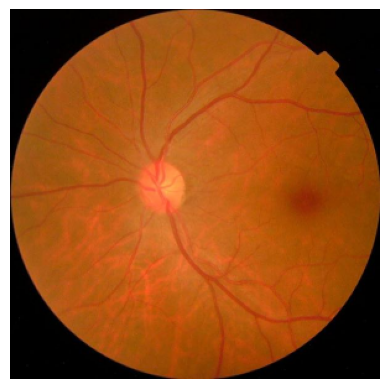

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted Class: Proliferate_DR


In [44]:
# prompt: generate code to classify the DR by taking an image path as an input

from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.image as mping
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image_dataset_from_directory
import cv2
import numpy as np
import random

drive.mount('/content/drive')

# Check if directories exist, create if not
if not os.path.exists('~/.kaggle'):
  ! mkdir ~/.kaggle
if not os.path.exists('/content/drive/MyDrive/ColabNotebooks/KAGGLEAPI/kaggle.json'):
    print("kaggle.json does not exists in the path /content/drive/MyDrive/ColabNotebooks/KAGGLEAPI/kaggle.json, you must create a path and add your kaggle.json")

else :
  ! cp /content/drive/MyDrive/ColabNotebooks/KAGGLEAPI/kaggle.json ~/.kaggle/kaggle.json
  ! chmod 600 ~/.kaggle/kaggle.json

  if not os.path.exists('eyepacs-aptos-messidor-diabetic-retinopathy.zip') :
      ! kaggle datasets download ascanipek/eyepacs-aptos-messidor-diabetic-retinopathy
      !unzip eyepacs-aptos-messidor-diabetic-retinopathy.zip

def random_image(val_dir,val_class):
    folder = val_dir + val_class
    if not os.path.exists(folder) :
      print(f"{folder} path does not exists")
      return
    random_image = random.sample(os.listdir(folder),1)
    img = mping.imread(folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(val_class)
    return img

train_dir = "/content/dr_unified_v2/dr_unified_v2/train"
test_dir =  "/content/dr_unified_v2/dr_unified_v2/test"
val_dir = "/content/dr_unified_v2/dr_unified_v2/val"

# Check if directories exists if not print a warning message
if not os.path.exists(train_dir) or not os.path.exists(test_dir) or not os.path.exists(val_dir) :
    print(f"You must have your folders {train_dir}, {test_dir}, {val_dir} created, these folders must have folders inside with the classes")
else:

  train_data = image_dataset_from_directory(train_dir,label_mode = "categorical", image_size = (299,299),batch_size = 64, shuffle = True,seed = 42)
  test_data = image_dataset_from_directory(test_dir,label_mode = "categorical", image_size = (299,299),batch_size = 64, shuffle = False,seed = 42)
  val_data = image_dataset_from_directory(val_dir,label_mode = "categorical", image_size = (299,299),batch_size = 64, shuffle = False,seed = 42)
  early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6, min_delta = 0.0001)
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2, patience = 6, min_lr = 1e-7)
  model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
  model.trainable = False

  inputs = layers.Input(shape = (299,299,3),name = "input_layer")
  x = model(inputs)
  x = layers.GlobalAvgPool2D(name = "pooling_layer")(x)
  x = layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.2), kernel_initializer=tf.keras.initializers.he_normal())(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(5)(x)
  outputs = layers.Activation("softmax",dtype = tf.float32)(x)
  model = tf.keras.Model(inputs,outputs)
  model.summary()
  model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])
  history = model.fit(train_data,epochs =1 , validation_data = val_data, callbacks = [early_stop,reduce_lr])
  print("Testing Accuracy",model.evaluate(test_data))
  model.save('trained_model.keras')

  # Load the model with custom activation
  model = tf.keras.models.load_model('trained_model.keras', custom_objects={'LeakyReLU': LeakyReLU})

  # Check if model loads correctly
  model.summary()

def predict_class(path):
    img = cv2.imread(path)
    if img is None:
        print(f"Error: Image at {path} could not be loaded.")
        return

    RGBImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    RGBImg = cv2.resize(RGBImg, (299, 299)) # Resize to the correct input shape
    plt.imshow(RGBImg)
    plt.axis('off')
    plt.show()
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("trained_model.keras", custom_objects={'LeakyReLU': LeakyReLU})
    predict = new_model.predict(np.array([image]))
    per = np.argmax(predict, axis=1)
    class_map = {
        0: 'No_DR',
        1: 'Mild',
        2: 'Moderate',
        3: 'Severe',
        4: 'Proliferate_DR'
    }
    print(f'Predicted Class: {class_map[per[0]]}')

# Example usage, change the path to your test image
predict_class(r"/content/augmented_resized_V2/test/0/08ee569d4721-600.jpg")



In [52]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, RepeatVector, TimeDistributed, Concatenate
import numpy as np
import pickle
import os

def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))  # Resize to InceptionV3 input size
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

                    # Load pre-trained InceptionV3 for feature extraction
base_model = InceptionV3(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)  # Extract features from last layer

def extract_features(image_path, model):
     img = load_and_preprocess_image(image_path)
     features = model.predict(img)
     return features

                                # Sample word dictionary (For a real model, use a trained tokenizer)
id_to_word = {0: "No DR", 1: "Mild DR", 2: "Moderate DR", 3: "Severe DR", 4: "Proliferative DR"}

def generate_caption(image_path, model):
     features = extract_features(image_path, model)
     prediction = np.argmax(features)  # Mock classification (replace with real trained LSTM model)
     return id_to_word.get(prediction,"The generated has hemorages")

                                            # Example Usage:
image_path = "/content/augmented_resized_V2/test/0/08ee569d4721-600.jpg"
caption = generate_caption(image_path, model)
print(f'Generated Caption: {caption}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Generated Caption: The generated has hemorages


In [50]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

# Load captions dataset (if available)
captions = ["No DR", "Mild DR", "Moderate DR", "Severe DR", "Proliferative DR"]  # Example captions

# Initialize and fit tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)

# Save the tokenizer for future use
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [51]:
# Load the saved tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

    # Convert generated index to text using the tokenizer
def generate_caption(image_path, model):
     features = extract_features(image_path, model)
     prediction = np.argmax(features)  # Replace with a real LSTM model prediction

                # Convert index to word using the tokenizer
     caption = tokenizer.index_word.get(prediction, "Unknown")
     return caption


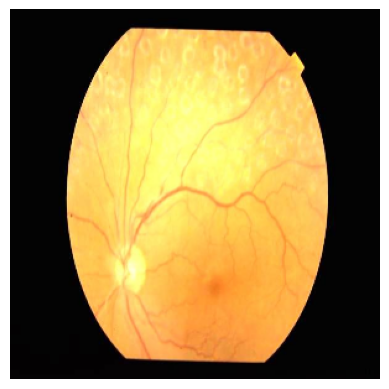

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Class: No_DR


In [47]:
predict_class(r"/content/augmented_resized_V2/test/3/069f43616fab-600-FA.jpg")